In [9]:
import os
from contextlib import suppress

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pycraf
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from astropy.time import Time
# Note: if the progress bar is not correctly rendered, try the
# following commands in the terminal (requires nodejs):
# jupyter nbextension enable --py widgetsnbextension
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# from astropy.utils.console import ProgressBar
from tqdm import trange
from astropy.utils.misc import NumpyRNGContext
from scipy.stats import percentileofscore
import cysgp4

In [10]:
pjoin = os.path.join   ### this is just a alias to join paths?

FIGPATH = '../figs'
DATAPATH = '../data'

with suppress(IOError):
    os.makedirs(FIGPATH)

with suppress(IOError):
    os.makedirs(DATAPATH)

### constellation model

In [11]:
def create_constellation(mjd_epoch, altitudes, inclinations, nplanes, sats_per_plane, mas_offsets=None):
    
    my_sat_tles = []
    sat_nr = 1
    for alt, inc, n, s in zip(
            altitudes, inclinations, nplanes, sats_per_plane
            ):
        
        if s == 1:
            # random placement for lower orbits
            mas = np.random.uniform(0, 360, n)
            raans = np.random.uniform(0, 360, n)
        else:
            mas = np.linspace(0.0, 360.0, s, endpoint=False)
            if mas_offsets is None:
                mas_off = np.random.uniform(0, 360, n)
            else:
                mas_off = mas_offsets
            raans = np.linspace(0.0, 360.0, n, endpoint=False)
            mas, raans = np.meshgrid(mas, raans)
            mas += mas_off[:, np.newaxis]
            mas, raans = mas.flatten(), raans.flatten()
        
        mm = cysgp4.satellite_mean_motion(alt)
        for ma, raan in zip(mas, raans):
            my_sat_tles.append(
                cysgp4.tle_linestrings_from_orbital_parameters(
                    'TEST {:d}'.format(sat_nr), sat_nr, mjd_epoch,
                    inc, raan, 0.001, 0., ma, mm
                    ))
                
            sat_nr += 1
    
    return my_sat_tles

In [12]:
def sample_on_cell_grid_m1583(
        niters,
        step_size=3 * u.deg,
        lat_range=(0 * u.deg, 90 * u.deg),
        rnd_seed=None,
        ):

    def sample(niters, low_lon, high_lon, low_lat, high_lat):

        z_low, z_high = np.cos(np.radians(90 - low_lat)), np.cos(np.radians(90 - high_lat))
        az = np.random.uniform(low_lon, high_lon, size=niters)
        el = 90 - np.degrees(np.arccos(
            np.random.uniform(z_low, z_high, size=niters)
            ))
        return az, el

    cell_edges, cell_mids, solid_angles, tel_az, tel_el = [], [], [], [], []

    lat_range = (lat_range[0].to_value(u.deg), lat_range[1].to_value(u.deg))
    ncells_lat = int(
        (lat_range[1] - lat_range[0]) / step_size.to_value(u.deg) + 0.5
        )
    edge_lats = np.linspace(
        lat_range[0], lat_range[1], ncells_lat + 1, endpoint=True
        )
    mid_lats = 0.5 * (edge_lats[1:] + edge_lats[:-1])

    with NumpyRNGContext(rnd_seed):
        for low_lat, mid_lat, high_lat in zip(edge_lats[:-1], mid_lats, edge_lats[1:]):

            ncells_lon = int(360 * np.cos(np.radians(mid_lat)) / step_size.to_value(u.deg) + 0.5)
            edge_lons = np.linspace(0, 360, ncells_lon + 1, endpoint=True)
            mid_lons = 0.5 * (edge_lons[1:] + edge_lons[:-1])

            solid_angle = (edge_lons[1] - edge_lons[0]) * np.degrees(
                np.sin(np.radians(high_lat)) - np.sin(np.radians(low_lat))
                )
            for low_lon, mid_lon, high_lon in zip(edge_lons[:-1], mid_lons, edge_lons[1:]):
                cell_edges.append((low_lon, high_lon, low_lat, high_lat))
                cell_mids.append((mid_lon, mid_lat))
                solid_angles.append(solid_angle)
                cell_tel_az, cell_tel_el = sample(niters, low_lon, high_lon, low_lat, high_lat)
                tel_az.append(cell_tel_az)
                tel_el.append(cell_tel_el)

    tel_az = np.array(tel_az).T  # TODO, return u.deg
    tel_el = np.array(tel_el).T

    grid_info = np.column_stack([cell_mids, cell_edges, solid_angles])
    grid_info.dtype = np.dtype([  # TODO, return a QTable
        ('cell_lon', np.float64), ('cell_lat', np.float64),
        ('cell_lon_low', np.float64), ('cell_lon_high', np.float64),
        ('cell_lat_low', np.float64), ('cell_lat_high', np.float64), 
        ('solid_angle', np.float64), 
        ])
    
    return tel_az, tel_el, grid_info[:, 0]

### Define observer position.

In [13]:
# In[4]:


# # Observer:

# observer_name = 'geolat_0deg'
# observer_tname = 'RAS @ lat = 0 deg'
# obs_lon, obs_lat, obs_alt = 0., 0., 0.  # deg, deg, km
# eq_lat_range = (-80 * u.deg, 80 * u.deg)
# d_rx = 100 * u.m

observer_name = 'geolat_50deg'
observer_tname = 'RAS @ lat = 50 deg'
obs_lon, obs_lat, obs_alt = 0., 50., 0.  # deg, deg, km
eq_lat_range = (-30 * u.deg, 90 * u.deg)
d_rx = 25 * u.m

# observer_name = 'geolat_50deg_70m'
# observer_tname = 'RAS @ lat = 50 deg - D = 70m'
# obs_lon, obs_lat, obs_alt = 0., 50., 0.  # deg, deg, km
# eq_lat_range = (-30 * u.deg, 90 * u.deg)
# d_rx = 70 * u.m


# observer_name = 'geolat_30deg'
# observer_tname = 'RAS @ lat = 30 deg'
# obs_lon, obs_lat, obs_alt = 0., 30., 0.  # deg, deg, km
# eq_lat_range = (-30 * u.deg, 90 * u.deg)
# d_rx = 25 * u.m


# observer_name = 'geolat_80deg'
# observer_tname = 'RAS @ lat = 80 deg'
# obs_lon, obs_lat, obs_alt = 0., 80., 0.  # deg, deg, km
# eq_lat_range = (0 * u.deg, 90 * u.deg)
# d_rx = 100 * u.m

# Rx (RAS) parameters
eta_a_rx = 100 * u.percent

### Define EPFD simulation meta parameters.

In [14]:
# In[41]:


min_elevation = 5 * u.deg
grid_size = 3. * u.deg
niters = 2000
time_range, time_resol = 10, 1  # seconds
activity_cycle = 1
sat_frame = 'zxy'


# In[42]:

ras_tab = protection.ra769_limits(mode='continuum')[3] # 150 MHz RAS band
# ras_tab = protection.ra769_limits(mode='continuum')[7] # 1.4 GHz RAS band
print(ras_tab)

frequency bandwidth T_A T_rx T_rms  P_rms_nu   Plim   Plim_nu      Slim        Slim_nu        Efield    Efield_norm 
   MHz       MHz     K   K     mK  dB(W / Hz) dB(W)  dB(W / Hz) dB(W / m2) dB(W / (Hz m2)) dB(uV2 / m2) dB(uV2 / m2)
--------- --------- --- ---- ----- ---------- ------ ---------- ---------- --------------- ------------ ------------
      152         3 150   60 2.734     -254.2 -199.5     -264.2     -194.5          -259.2        -48.7        -53.4


### Note, the following constellation/satellite parameters are preliminary. CRAF is still in the process to talk to the satellite operators to work out the final technical parameters.

In [15]:
# Simulated satellites

# start_times_window = 1 * u.hour
start_times_window = 24 * u.hour
# start_times_window = 720 * u.hour

designation = ['UEMR_Test'+str(k) for k in range(16)]
constellation_name = ['UEMR_Test'+str(k) for k in range(16)]

# constellation parameters
altitudes      = np.array([400,500,700,900,400,500,700,900,400,500,700,900,400,500,700,900])
inclinations   = np.array([55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55])
nplanes        = np.array([20, 20, 20, 20, 20, 20, 20, 20, 50, 50, 50, 50, 60, 60, 60, 60])
sats_per_plane = np.array([5,  5,  5,  5,  25, 25, 25, 25, 20, 20, 20, 20, 80, 80, 80, 80])

# designation = ['UEMR_Test17_margin']
# constellation_name = ['UEMR_Test17_margin']

# # constellation parameters
# altitudes      = np.array([400])
# inclinations   = np.array([55])
# nplanes        = np.array([20])
# sats_per_plane = np.array([5])


# general parameters
freq = ras_tab['frequency']

p_lim = ras_tab['Plim']
pfd_lim = ras_tab['Slim']
ras_bandwidth = ras_tab['bandwidth']

--------------------------------------------------------------------------------
Starting epfd sim
Constellation: UEMR_Test0
Altitude: 400.00
Inclination: 55.00
Number of planes: 20.00
Sats per plane: 5.00
total number of satellites 100
Observer Name: RAS @ lat = 50 deg
Observer lon: 0.00
Observer lat: 50.00
--------------------------------------------------------------------------------
Frequency: 151.53 MHz
EIRP (into RAS band): -48.70 dB(mW / MHz) -138.7 dB(W / Hz)
--------------------------------------------------------------------------------
niters: 2000, time steps: 10


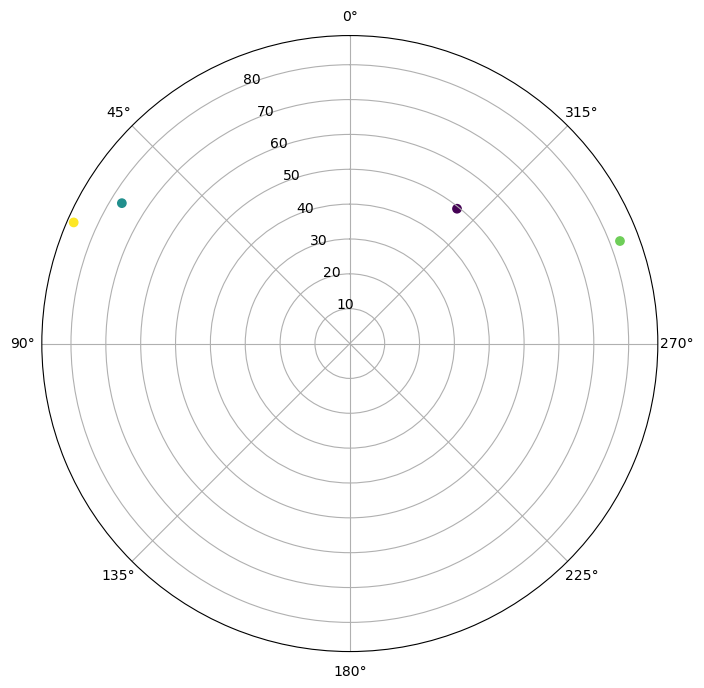

--------------------------------------------------------------------------------
Minimum elevation: 5.00 deg
Number of cells: 2067
--------------------------------------------------------------------------------


100%|██████████| 2000/2000 [00:35<00:00, 56.22it/s]


data loss (total): 1.79 (+0.97 / -0.92) %
number of sky cells above threshold: 357 (17.27 %)


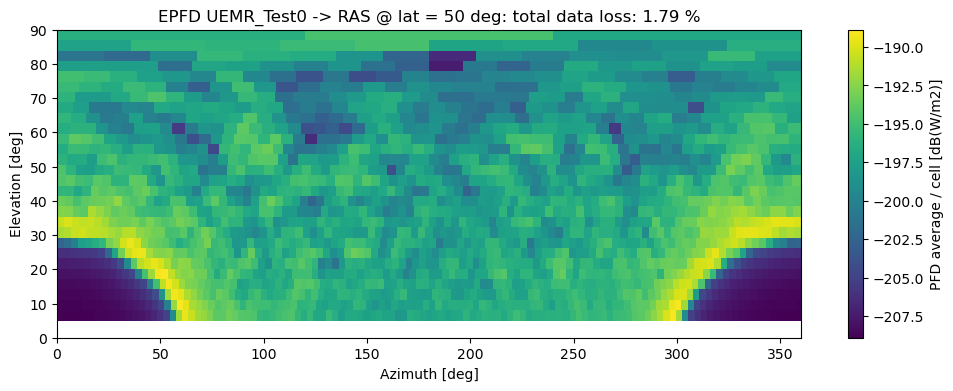

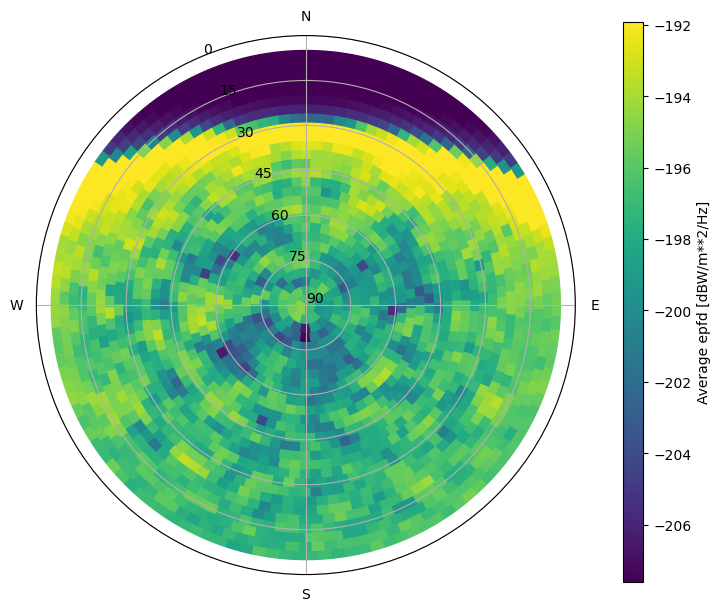

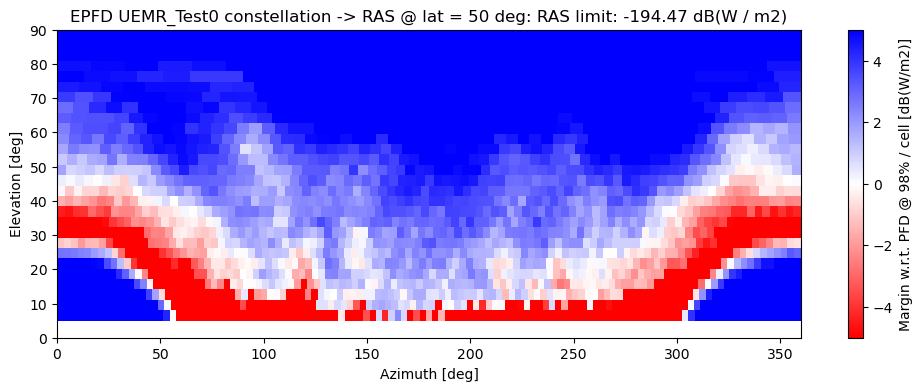

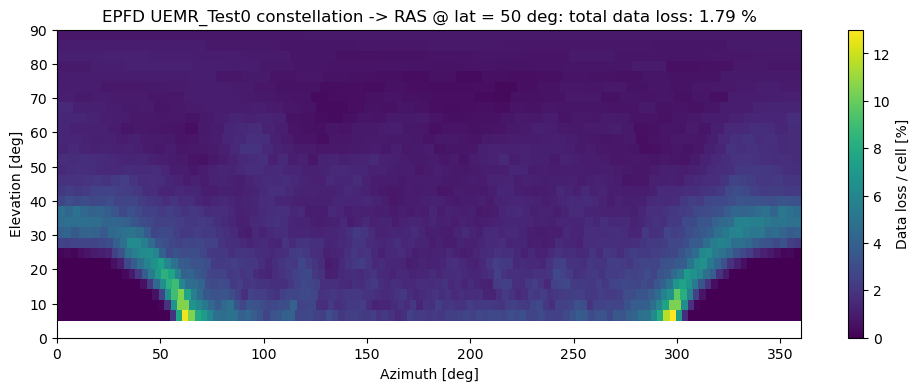

98%: pfd = -195.1 (+2.5 / -4.2) dB(W / m2)
RAS margin = 0.7 (+4.2 / -2.5) dB


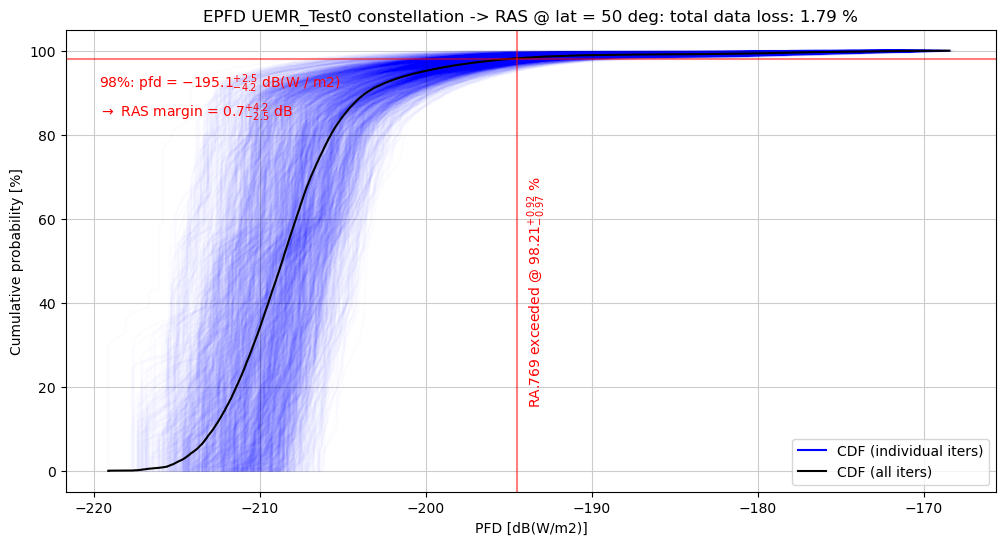

(0.0, 360.0)

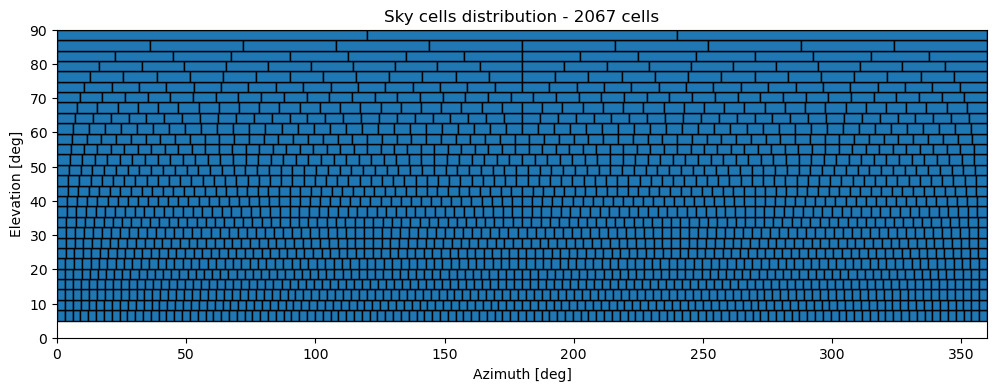

In [16]:
# Tx (Sat) parameters

# the following numbers are for one channel only!!!

#*********** MARGIN ***************
#*********** MARGIN ***************
margin = 0
#*********** MARGIN ***************
#*********** MARGIN ***************

p_tx_carrier = (-44+margin) * cnv.dBm #CISPR22 maximum emission at 150 MHz is -44 dBm
carrier_bandwidth = ras_tab['bandwidth'] #this is not specified in the french section...
duty_cycle = 100 * u.percent


p_tx_nu_peak = (
    p_tx_carrier.physical / carrier_bandwidth
    ).to(u.W / u.Hz)
p_tx_nu = p_tx_nu_peak * duty_cycle
p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth
p_tx = p_tx_carrier

def sat_gain_func(sat_obs_az, sat_obs_el):
    # Use 0 dBi antenna for the simulations
    
    sat_obs_az, sat_obs_el = np.broadcast_arrays(sat_obs_az, sat_obs_el)
    G_tx = np.zeros(sat_obs_az.shape, dtype=np.float64) * cnv.dBi
    return G_tx


#%% Start the iteration process over all the constellations options
# date = Time.now()
# csv_filename = 'UEMR tests - '+ date.strftime('%d-%m-%y') 

# fp = open(f"{csv_filename}.csv", "w")
# fp.write('Constellation_name, altitudes, inclinations, nplanes, sats_per_plane,\
#             p_tx_carrier [dBm], freq [MHz], carrier_bandwidth [MHz], \
#             p_lim [dBm],niters, time_range, time_resol,Ncells,data_loss,\
#             Margin\n')
    
for sat_indx in range(1):#0,16,1):#len(constellation_name)):

    basename = '{:s}_{:s}_{:s}'.format(designation[sat_indx], observer_name,freq)
   
    
    # Define a custom print function, to store results in text files.
    infofile = open(pjoin(DATAPATH, basename + '_info_and_results.txt'), 'w')
    def print_info(*args, **kwargs):
        print(*args, **kwargs)
        print(*args, **kwargs, file=infofile)
        infofile.flush()
    
        
    ## Preparing the constellation
    
    # want epoch for the following time
    mjd_epoch = 58813.5
    pydt = cysgp4.PyDateTime.from_mjd(mjd_epoch)
    
    
    print_info('-' * 80)
    print_info('Starting epfd sim')
    print_info('Constellation: %s'%constellation_name[sat_indx])
    print_info('Altitude: {0:.2f}'.format(altitudes[sat_indx]))
    print_info('Inclination: {0:.2f}'.format(inclinations[sat_indx]))
    print_info('Number of planes: %.2f'%nplanes[sat_indx])
    print_info('Sats per plane: %.2f'%sats_per_plane[sat_indx])
    
    sats_tle_tuples = create_constellation(
        mjd_epoch, [altitudes[sat_indx]],[inclinations[sat_indx]], [nplanes[sat_indx]], [sats_per_plane[sat_indx]]
        ) 
        
    print_info('total number of satellites', len(sats_tle_tuples))
    
    print_info('Observer Name: %s'%observer_tname)
    print_info('Observer lon: %.2f'%obs_lon)
    print_info('Observer lat: %.2f'%obs_lat)

    print_info('-' * 80)    

    print_info('Frequency: {0:.2f}'.format(freq))
    print_info('EIRP (into RAS band): {:.2f} {:.1f}'.format(
        p_tx_nu.to(cnv.dBm_MHz), p_tx_nu.to(cnv.dB_W_Hz)
        ))

    print_info('-' * 80)    

    sats_tles = np.array([
        cysgp4.PyTle(*tle)
        for tle in sats_tle_tuples
        ])
    
    start_mjd = mjd_epoch
    # start each simulation iteration at a random time, spread over a day
    start_times = start_mjd + np.random.uniform(0, 1, niters) * start_times_window.to_value(u.day)
    td = np.arange(0, time_range, time_resol) / 86400.  # 2000 s in steps of 1 s
    mjds = start_times[:, np.newaxis] + td[np.newaxis]
    
    print_info('niters: {:d}, time steps: {:d}'.format(niters, len(td)))


    ras_observer = cysgp4.PyObserver(obs_lon, obs_lat, obs_alt)


    # Simulate satellite positions of full constellation for each iteration run.
    
    result = cysgp4.propagate_many(  # see cysgp4 manual for details, propagation to calculate distance with tles
        mjds[:, :, np.newaxis],
        sats_tles[np.newaxis, np.newaxis, :],
        ras_observer,
        do_sat_azel=True, sat_frame=sat_frame,
        )
    
    eci_pos = result['eci_pos']
    topo_pos = result['topo']
    sat_azel = result['sat_azel']  ### check cysgp4 for satellite frame orientation description
    
    eci_pos_x, eci_pos_y, eci_pos_z = (eci_pos[..., i] for i in range(3))
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
    sat_obs_az, sat_obs_el, sat_obs_dist = (sat_azel[..., i] for i in range(3))

        
    #some test plots:
    # Polar view of the sky
    fig = plt.figure(figsize=[10,8])
    axs = plt.subplot(projection='polar')
    axs.set_theta_zero_location("N")
    axs.set_title('')
    
    
    axs.scatter(topo_pos[0,0,topo_pos[0,0,:,1]>0,0]*np.pi/180,
             90-topo_pos[0,0,topo_pos[0,0,:,1]>0,1],
             c = topo_pos[0,0,topo_pos[0,0,:,1]>0,2])
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_sats_pos_sky_view.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show()
    
    # ***** 3D plot
    Re = const.R_earth.value
    phi = np.linspace(0*u.deg, 360*u.deg, 100)
    theta = np.linspace(0*u.deg, 180*u.deg, 100)
    THETA, PHI = np.meshgrid(np.deg2rad(theta),
                              np.deg2rad(phi))
    # Cartesian sphere 
    Xe = Re * np.sin(THETA) * np.cos(PHI)/1e3
    Ye = Re * np.sin(THETA) * np.sin(PHI)/1e3
    Ze = Re * np.cos(THETA)/1e3
  
     
#     fig = plt.figure(figsize=[10,8])
#     axs = plt.subplot(projection='3d')
#     axs.set_title('')
    
#     axs.plot_wireframe(Xe,Ye,Ze,color='black',alpha=0.1,linewidth=1,zorder = 0)
    
#     axs.scatter(eci_pos[0,0,(topo_pos[0,0,:,1]<=0) & (eci_pos[0,0,:,0]>=0),0],
#                 eci_pos[0,0,(topo_pos[0,0,:,1]<=0) & (eci_pos[0,0,:,0]>=0),1],
#                 eci_pos[0,0,(topo_pos[0,0,:,1]<=0) & (eci_pos[0,0,:,0]>=0),2],
#                 alpha=1,
#                 s=2, color = 'blue',zorder=50)
    
#     axs.view_init(0,0,'z')

#     plt.savefig(
#          f'{FIGPATH}/{basename}test_sats_pos_3D_view.png',
#         bbox_inches='tight', dpi=100,
#         )

#     plt.show()
   
    
    # Create grid
    tel_az, tel_el, grid_info = sample_on_cell_grid_m1583(
        niters,
        step_size=grid_size,
        lat_range=(min_elevation, 90 * u.deg),
        rnd_seed=0,
        )
    print_info('-' * 80)
    print_info('Minimum elevation: {0:.2f}'.format(min_elevation))
    print_info('Number of cells: {0:d}'.format(len(grid_info)))
    print_info('-' * 80)


    p_rx = np.zeros(tel_az.shape, dtype=np.float64)
    
    # doing the calculation for all iterations and sky cells at once
    # is very memory consuming; process data in chunks (of sky cells)
    chunk_size = 100
    nchunks = tel_az.shape[1] // chunk_size + 1
    
    # for niter in ProgressBar(niters, ipython_widget=True):
    for niter in trange(niters):
        # calculating the angular separations for every satellite is extremely
        # slow, need to apply visibility masks from the beginning...
        # note: even if min_elev is different from zero, satellites barely
        # above the horizon can contribute to cells at higher elevation
        vis_mask = topo_pos_el[niter] > 0.
            
        if np.count_nonzero(vis_mask)>0:
            FSPL = cnv.free_space_loss(
                sat_obs_dist[niter, vis_mask, np.newaxis] * u.km, freq
                ).to(cnv.dB)
        
            G_tx = sat_gain_func(
                sat_obs_az[niter, vis_mask, np.newaxis] * u.deg,
                sat_obs_el[niter, vis_mask, np.newaxis] * u.deg,
                )
            
            
            for chunk in range(nchunks):
                
                cells_sl = slice(
                    chunk * chunk_size, 
                    min((chunk + 1) * chunk_size, tel_az.shape[1])
                    )
         
                ang_sep_topo = geometry.true_angular_distance(
                    tel_az[niter, np.newaxis, cells_sl] * u.deg,
                    tel_el[niter, np.newaxis, cells_sl] * u.deg,
                    topo_pos_az[niter, vis_mask, np.newaxis] * u.deg,
                    topo_pos_el[niter, vis_mask, np.newaxis] * u.deg,
                    )
        
        
                G_rx = antenna.ras_pattern(
                    ang_sep_topo, d_rx, const.c / freq, eta_a_rx
                    )
        
        
                # Calculate average received power over the integration time
                _p_rx = np.sum(
                    (p_tx.to(cnv.dB_W) + G_tx + FSPL + G_rx).to_value(u.W),
                    axis=0
                    ) / mjds.shape[1] * activity_cycle
                
                
                p_rx[niter, cells_sl] = _p_rx 


    # Store result for later use (e.g., in apportionment or other analyses)
    
    prx_file = pjoin(DATAPATH, basename + '_horizontal_prx.npy')
    aux_file = pjoin(DATAPATH, basename + '_horizontal_aux.npz')


    np.save(prx_file, p_rx)
    np.savez(
        aux_file,
        tel_az=tel_az,
        tel_el=tel_el,
        grid_info=grid_info,
        pfd_lim_W_m2=pfd_lim.to_value(u.W / u.m ** 2),
        frequency_ghz=freq.to_value(u.GHz),
        designations=(designation, constellation_name),
        observer_names=(observer_name, observer_tname),
        obs_pos=(obs_lon, obs_lat, obs_alt),
        )

    # to load:
    # p_rx = np.load(prx_file)
    # _aux = np.load(aux_file)
    # tel_az = _aux['tel_az']
    # tel_el = _aux['tel_el']
    # grid_info = _aux['grid_info']
    # pfd_lim = _aux['pfd_lim_W_m2'] * u.W / u.m ** 2
    # freq = _aux['frequency_ghz'] * u.GHz
    # designation, constellation_name = _aux['designations']
    # observer_name, observer_tname = _aux['observer_names']
    # obs_lon, obs_lat, obs_alt = _aux['obs_pos']


    #fix negative results
    p_rx[p_rx < 1.e-89] = 1.e-89


    # calculate pfd from received power (receiver gain was already accounted for!)
    pfd = (cnv.powerflux_from_prx(p_rx * 1e60 * u.W, freq, 0 * cnv.dBi) * 1e-60).to(cnv.dB_W_m2)
    
    pfd_lin = pfd.to_value(u.W / u.m ** 2)
    pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
    pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
    pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
    
    _pfd_lim_W_m2 = pfd_lim.to_value(u.W / u.m ** 2)
    
    #data loss per cell
    data_loss_per_cell = np.array([
        100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
        for pl in pfd_lin.T
        ])
    
    #total data loss
    data_loss = (
        100 - percentileofscore(pfd_lin.flatten(), _pfd_lim_W_m2, kind='strict')
        ) * u.percent


    #data loss per iteration, looking at all the cells     
    data_loss_per_iteration = np.array([
        100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
        for pl in pfd_lin
        ])
    
    data_loss_mean = np.mean(data_loss_per_iteration)
    
    data_loss_m1s, data_loss_median, data_loss_p1s = np.percentile(
        data_loss_per_iteration, [15.865, 50., 84.135]
        )


    print_info(
        'data loss (total): {0.value:.2f} (+{1:.2f} / -{2:.2f}) {0.unit}'.format(
            data_loss,
            data_loss_p1s - data_loss.to_value(u.percent),
            data_loss.to_value(u.percent) - data_loss_m1s,
        ))
    

    bad_cells = np.count_nonzero(pfd_avg > pfd_lim)
    print_info('number of sky cells above threshold: {0:d} ({1:.2f} %)'.format(
        bad_cells, 100 * bad_cells / len(grid_info)
        ))


    #rectangular plot, average PFD
    fig = plt.figure(figsize=(12, 4))
    val = pfd_avg.to_value(cnv.dB_W_m2)
    vmin, vmax = val.min(), val.max()
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('PFD average / cell [dB(W/m2)]')
    plt.title('EPFD {0:s} -> {1:s}: total data loss: {2:.2f}'.format(
        constellation_name[sat_indx], observer_tname, data_loss
        ))
    plt.xlabel('Azimuth [deg]')
    plt.ylabel('Elevation [deg]')
    plt.xlim((0, 360))
    plt.ylim((0, 90))
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_skygrid_avg_pfd_horizontal.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show()  
    
    #Polar plor - Average PFD
    fig = plt.figure(figsize=(10, 7))
    axs = plt.subplot(projection='polar')
    cax = fig.add_axes((0.83, 0.1, 0.02, 0.8)) #colorbar axes
    
    theta_l = np.radians(grid_info['cell_lon_low'])
    theta_h = np.radians(grid_info['cell_lon_high'])
    r_l = 1-grid_info['cell_lat_low']/90
    r_h = 1-grid_info['cell_lat_high']/90
    
    val = pfd_avg.to_value(cnv.dB_W_m2)
    val_min = np.percentile(val,5)
    val_max = np.percentile(val,95)
    val_norm = (val-val_min)/(val_max-val_min)
    
    my_cmap = plt.get_cmap("viridis")
    im = axs.bar(x=theta_l,
                 height=r_h-r_l, 
                 width=theta_h-theta_l, 
                 bottom=r_l,
                 color= my_cmap(val_norm),
                 edgecolor=my_cmap(val_norm))

    norm = matplotlib.colors.Normalize(vmin=val_min, vmax=val_max)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'),
                 label='Average epfd [dBW/m**2/Hz]',cax=cax)

    axs.set_theta_zero_location("N")
    axs.set_yticks( ticks = np.linspace(0,1,7),labels=[str(int(i)) for i in np.linspace(90,0,7)])
    axs.set_xticks( ticks = [0,np.pi/2,np.pi,3*np.pi/2],labels = ['N','W','S','E'])
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_skygrid_polar_avg_pfd_horizontal.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show() 

    #recatangular plot margin to RAS limit
    fig = plt.figure(figsize=(12, 4))
    val = pfd_lim.to_value(cnv.dB_W_m2) - pfd_98p.to_value(cnv.dB_W_m2)
    vmin, vmax = val.min(), val.max()
    vmin, vmax = -5, 5
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.bwr_r(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr_r, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Margin w.r.t. PFD @ 98% / cell [dB(W/m2)]')
    plt.title('EPFD {:s} constellation -> {:s}: RAS limit: {:.2f}'.format(
        constellation_name[sat_indx], observer_tname, pfd_lim
        ))
    plt.xlabel('Azimuth [deg]')
    plt.ylabel('Elevation [deg]')
    plt.xlim((0, 360))
    plt.ylim((0, 90))
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_skygrid_margin_wrt_98p_pfd_horizontal.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show()
    
    #plot data loss rectangular map    
    fig = plt.figure(figsize=(12, 4))
    val = data_loss_per_cell
    vmin, vmax = val.min(), val.max()
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Data loss / cell [%]')
    plt.title('EPFD {:s} constellation -> {:s}: total data loss: {:.2f}'.format(
        constellation_name[sat_indx], observer_tname, data_loss
        ))
    plt.xlabel('Azimuth [deg]')
    plt.ylabel('Elevation [deg]')
    plt.xlim((0, 360))
    plt.ylim((0, 90))
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_skygrid_data_loss_horizontal.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show()
    
    
    # Calculate margin at 98% percentile    
    pfd_dist = (np.sort(pfd_lin) * u.W / u.m ** 2).to(cnv.dB_W_m2)
    pfd_dist_all = (np.sort(pfd_lin.flatten()) * u.W / u.m ** 2).to(cnv.dB_W_m2)
    

    pfd98p = np.percentile(pfd_lin, 98., axis=1)
    pfd98p_db = (pfd98p * u.W / u.m ** 2).to_value(cnv.dB_W_m2)
    pfd98p_all = np.percentile(pfd_lin, 98.)
    pfd98p_all_db = (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2)
    pfd98p_m_db, pfd98p_p_db = np.percentile(pfd98p_db, [50 - 34.1, 50 + 34.1])

    
    print_info(
        '98%: pfd = {0.value:.1f} (+{1:.1f} / -{2:.1f}) {0.unit}'.format(
            pfd98p_all_db * cnv.dB_W_m2,
            pfd98p_p_db - pfd98p_all_db,
            pfd98p_all_db - pfd98p_m_db,
        ))
    
    
    print_info(
        'RAS margin = {:.1f} (+{:.1f} / -{:.1f}) dB'.format(
            pfd_lim.to_value(cnv.dB_W_m2) - pfd98p_all_db,
            pfd98p_all_db - pfd98p_m_db,
            pfd98p_p_db - pfd98p_all_db,
        ))
    
    
    #plot CDF
    
    fig = plt.figure(figsize=(12, 6))
    plt.plot(
        pfd_dist.T, 100 * np.linspace(0, 1, pfd_dist.shape[1], endpoint=True),
        'b-', alpha=0.01,
        )
    plt.plot([], [], 'b-', label='CDF (individual iters)')
    plt.plot(
        pfd_dist_all[::20], 100 * np.linspace(0, 1, pfd_dist_all.size, endpoint=True)[::20],
        'k-', label='CDF (all iters)'
        )
    hline = plt.axhline(98., color='r', alpha=0.5)
    vline = plt.axvline(pfd_lim.to_value(cnv.dB_W_m2), color='r', alpha=0.5)
    plt.grid(color='0.8')
    plt.title('EPFD {0:s} constellation -> {1:s}: total data loss: {2:.2f}'.format(
        constellation_name[sat_indx], observer_tname, data_loss
        ))
    plt.xlabel('PFD [dB(W/m2)]')
    plt.ylabel('Cumulative probability [%]')
    plt.legend(*plt.gca().get_legend_handles_labels())
    # plt.xlim((-330, -130))
    if observer_name == 'wettzell':
        plt.xlim((-300, -100))
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(
        xmin + 2, 95.,
        r'98%: pfd = ${0.value:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$ {0.unit}'.format(
            # (pfd98p_all * u.W / u.m ** 2).to(cnv.dB_W_m2),
            # np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            # np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            pfd98p_all_db * cnv.dB_W_m2,
            pfd98p_p_db - pfd98p_all_db,
            pfd98p_all_db - pfd98p_m_db,
            ), color='red', ha='left', va='top',
        )
    plt.text(
        xmin + 2, 88.,
        r'$\rightarrow$ RAS margin = ${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ dB'.format(
            # pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
            # np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            # np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            pfd_lim.to_value(cnv.dB_W_m2) - pfd98p_all_db,
            pfd98p_all_db - pfd98p_m_db,
            pfd98p_p_db - pfd98p_all_db,
            ), color='red', ha='left', va='top',
        )
    plt.text(
        pfd_lim.to_value(cnv.dB_W_m2) + 0.5, ymin + 20,
        r'RA.769 exceeded @ ${0.value:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$ {0.unit}'.format(
            100 * u.percent - data_loss,
            data_loss.to_value(u.percent) - data_loss_m1s,
            data_loss_p1s - data_loss.to_value(u.percent),
            ),
        color='red', ha='left', va='bottom', rotation=90.,
        )
#     plt.savefig(
#         pjoin(FIGPATH, '{0:s}_cumulative_data_loss_horizontal.png'.format(basename)),
#         bbox_inches='tight', dpi=100,
#         )
    plt.show()


    #******** Write the CSV with the results    
#     fp.write('%s,%.2f,%.2f,%.2f,%d,%d,%.2f,%.2f,%.2f,%d,%.2f,%.2f,%d,%.2f,%.2f\n'%(constellation_name[sat_indx], 
#                 altitudes[sat_indx], inclinations[sat_indx], nplanes[sat_indx], sats_per_plane[sat_indx],
#                 p_tx_carrier.to_value(cnv.dBm), freq.to_value(u.MHz), carrier_bandwidth.to_value(u.MHz), 
#                 p_lim.to_value(cnv.dBm),niters, time_range, time_resol,tel_az.shape[1],data_loss.value,
#                 pfd_lim.to_value(cnv.dB_W_m2) - pfd98p_all_db))
# fp.close()
infofile.close()


#%%plot sky cells distribution
fig = plt.figure(figsize=(12, 4))
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    align='edge',
    edgecolor='black'
    )
plt.title('Sky cells distribution - %d cells'%tel_az.shape[1])
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.ylim([0,90])
plt.xlim([0,360])